In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import pywt  # Added for wavelet transforms
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Support Vector Machine classifier
from sklearn.metrics import accuracy_score

from sklearn.base import BaseEstimator, TransformerMixin  # For custom transformer class

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

sys.path.append('../models')
from wavelet import WaveletTransformer, extract_wavelet_features

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Loading data and preprocessing
For all training, we are using the first 2 runs per subject for training and will hold out the 3rd run for live decoding testing.

In [2]:

models_dir = '../models/trained/'

print(__doc__)


# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) 
event_id = dict(hands=2, feet=3)


epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
#epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/nana/Documents/GitHub/eeg/data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


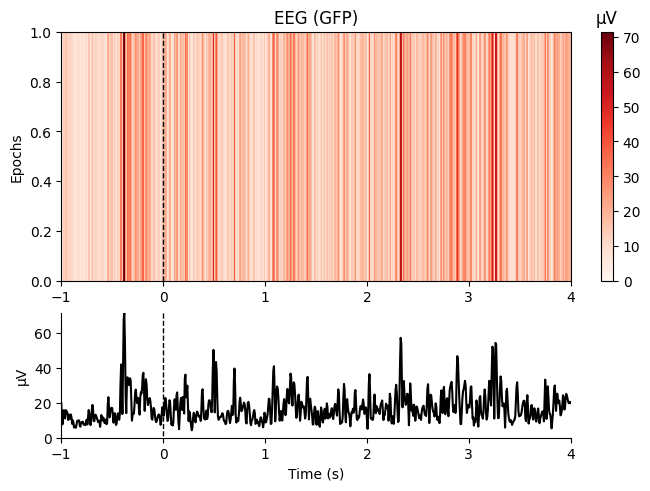

[<Figure size 640x480 with 3 Axes>]

In [3]:
epochs[0].plot_image()

### Feature decoding and classification

In [4]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
#epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)

In [5]:
# CSP + LDA

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Building Pipeline
clf = Pipeline([("CSP", csp), ("LDA", lda)])

# Fit the pipeline to the training data
clf.fit(epochs_data, labels)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_lda.pkl')
joblib.dump(clf, model_path)

scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=None)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
#csp.fit_transform(epochs_data, labels)
#csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 pr

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 pr

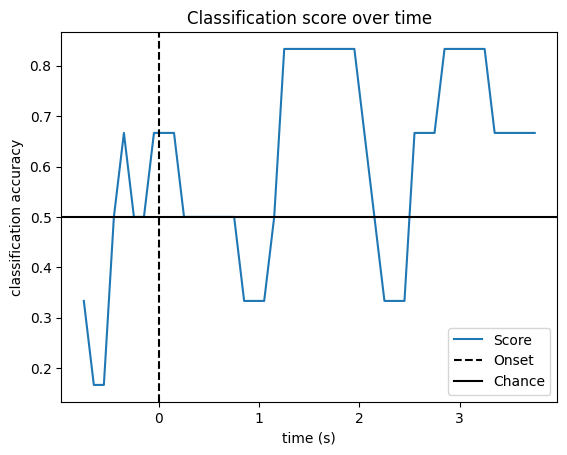

In [6]:
sfreq = raw.info["sfreq"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.2, random_state=42)

# Transform data using CSP and fit LDA classifier as before
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, X_test.shape[2] - w_length, w_step)

scores_windows = []

# Transform training data once, since we're not using cross-validation loop here
X_train_transformed = csp.fit_transform(X_train, y_train)

# Fit classifier to transformed training data
lda.fit(X_train_transformed, y_train)

# Running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    this_window = X_test[:, :, n : (n + w_length)]
    X_test_transformed = csp.transform(this_window)
    score_this_window.append(lda.score(X_test_transformed, y_test))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()


In [7]:
# CSP + Logistic Regression

lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_logistic.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + Logistic Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))



Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector E

In [8]:
# Wavelet + SVM

wavelet_transformer = WaveletTransformer(sfreq)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])

# Fit the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'wavelet_svm.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("Wavelet + SVM Regression Classification accuracy: %f / Chance level: %f" % (score, class_balance))


Wavelet + SVM Regression Classification accuracy: 0.666667 / Chance level: 0.666667


In [9]:
# CSP + SVM


csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])

# Fitting the pipeline to the training data
clf.fit(X_train, y_train)

# Save the trained model
model_path = os.path.join(models_dir, 'csp_svm.pkl')
joblib.dump(clf, model_path)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

# Printing the results
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + SVM Classification accuracy: %f / Chance level: %f" % (score, class_balance))

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector E